In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
BATCH_START = 0

# 一次完整LSTM训练经过的时间节点个数
TIME_STEPS = 20

# 每次训练的Batch大小
BATCH_SIZE = 50

# 输入的SIZE大小
INPUT_SIZE = 1

# 输出的SIZE大小
OUTPUT_SIZE = 1

# hidden units的个数
CELL_SIZE = 10

# 学习速率
LR = 0.006

In [3]:
def get_batch():
    global BATCH_START, TIME_STEPS
    # xs shape (50batch, 20steps)
    xs = np.arange(BATCH_START, BATCH_START + TIME_STEPS * BATCH_SIZE).reshape((BATCH_SIZE, TIME_STEPS)) / (10 * np.pi)
    seq = np.sin(xs)
    res = np.cos(xs)
    BATCH_START += TIME_STEPS
    
#     plt.plot(xs[0, :], res[0, :], 'r', xs[0, :], seq[0, :], 'b--')
#     plt.show()
    
    # returned seq, res and xs: shape(batch, step, input)
    return [seq[:, :, np.newaxis], res[:, :, np.newaxis], xs]

### LSTM Cell
![LSTM Cell](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

In [4]:
class LSTMRNN(object):
    def __init__(self, n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size
        self.batch_size = batch_size
        with tf.name_scope('inputs'):
            self.xs = tf.placeholder(tf.float32, [None, n_steps, input_size], name='xs')
            self.ys = tf.placeholder(tf.float32, [None, n_steps, output_size], name='ys')
        with tf.variable_scope('in_hidden', reuse=None):
            self.add_input_layer()
        with tf.variable_scope('LSTM_cell', reuse=None):
            self.add_cell()
        with tf.variable_scope('out_hidden', reuse=None):
            self.add_output_layer()
        with tf.name_scope('cost'):
            self.compute_cost()
        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(LR).minimize(self.cost)
    
    def add_input_layer(self):
        # 将xs reshape为 (batch * n_step, input_size)
        l_in_x = tf.reshape(self.xs, [-1, self.input_size], name='2_2D')
        # Ws (input_size, cell_size)
        Ws_in = self._weight_variable([self.input_size, self.cell_size])
        # bs (cell_size, )
        bs_in = self._bias_variable([self.cell_size, ])
        with tf.name_scope('Wx_plus_b'):
            l_in_y = tf.matmul(l_in_x, Ws_in) + bs_in
        # reshape l_in_y ==> (batch, n_steps, cell_size)
        self.l_in_y = tf.reshape(l_in_y, [-1, self.n_steps, self.cell_size], name='2_3D')
        
    def add_cell(self):
        # BasicLSTMCell()的第一个参数是cell_size
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(self.cell_size, forget_bias=1.0, state_is_tuple=True)
        with tf.name_scope('initial_state'):
            self.cell_init_state = lstm_cell.zero_state(self.batch_size, dtype=tf.float32)
        self.cell_outputs, self.cell_final_state = tf.nn.dynamic_rnn(
            lstm_cell, self.l_in_y, initial_state=self.cell_init_state, time_major=False)
    
    def add_output_layer(self):
        # cell_outputs是一个3-D数据，需要转化成2-D数据传给l_out_x
        # shape = (batch * steps, cell_size)
        l_out_x = tf.reshape(self.cell_outputs, [-1, self.cell_size], name='2_2D')
        Ws_out = self._weight_variable([self.cell_size, self.output_size])
        bs_out = self._bias_variable([self.output_size, ])
        # shape = (batch * steps, output_size)
        with tf.name_scope('Wx_plus_b'):
            self.pred = tf.matmul(l_out_x, Ws_out) + bs_out
    
    def compute_cost(self):
        # 这里的losses计算出的是一个batch中每一步的loss，因此后面计算cost的时候需要
        # 先乘以batch_size
        losses = tf.contrib.legacy_seq2seq.sequence_loss_by_example(
            [tf.reshape(self.pred, [-1], name='reshape_pred')],
            [tf.reshape(self.ys, [-1], name='reshape_target')],
            [tf.ones([self.batch_size * self.n_steps], dtype=tf.float32)],
            average_across_timesteps=True,
            softmax_loss_function=self.ms_error,
            name='losses'
        )
        with tf.name_scope('average_cost'):
            self.cost = tf.div(
                tf.reduce_sum(losses, name='losses_sum'),
                self.batch_size,
                name='average_cost'
            )
            tf.summary.scalar('cost', self.cost)
    
    
    @staticmethod
    def ms_error(labels, logits):
        return tf.square(tf.subtract(labels, logits))

    def _weight_variable(self, shape, name='weights'):
        initializer = tf.random_normal_initializer(mean=0, stddev=1.,)
        return tf.get_variable(shape=shape, initializer=initializer, name=name)

    def _bias_variable(self, shape, name='biases'):
        initializer = tf.constant_initializer(0.1)
        return tf.get_variable(name=name, shape=shape, initializer=initializer)

cost:  13.1589
cost:  4.1989
cost:  3.249
cost:  2.5044
cost:  0.7286
cost:  0.385
cost:  0.2334
cost:  0.1225
cost:  0.0512
cost:  0.018


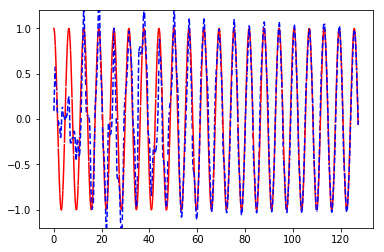

In [5]:
if(__name__ == '__main__'):
    model = LSTMRNN(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    sess = tf.Session()
    
    # TensorBoard通过读取Tensorflow事件(event)文件进行操作，该文件包括tensorflow
    # 运行过程中生成的摘要数据(summary data)。
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    # ion是交互模式
    plt.ion()
    plt.show()
    
    for i in range(200):
        seq, res, xs = get_batch()
        if(i == 0):
            feed_dict = {
                model.xs: seq,
                model.ys: res
            }
        else:
            feed_dict = {
                model.xs: seq,
                model.ys: res,
                model.cell_init_state: state   # use last state as the initial state for this run
            }
        
        _, cost, state, pred = sess.run([model.train_op, model.cost, model.cell_final_state, model.pred], feed_dict=feed_dict)
        
        # plotting
        plt.plot(xs[0, :], res[0].flatten(), 'r', xs[0, :], pred.flatten()[:TIME_STEPS], 'b--')
        plt.ylim((-1.2, 1.2))
        plt.draw()
        plt.pause(0.3)
        
        if(i % 20 == 0):
            print('cost: ', round(cost, 4))
            result = sess.run(merged, feed_dict)
            writer.add_summary(result, i)